In [0]:
pip install git+https://github.com/deepmind/dm-haiku

- Importing necessary modules

In [0]:
%matplotlib inline
%config InlinrBackend.figure_format = 'retina'

In [0]:
import jax
import time
import haiku as hk
import jax.numpy as jnp
import numpy as onp
import pandas as pd
from jax import random
import seaborn as sns
from IPython import  display
from jax import grad,jit,vmap,value_and_grad
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [0]:
          #importing optimizers from JAX
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

In [0]:
           #Generate key which is used to generate random numbers..
           #pseudorandom number generator (PRNG)
key = random.PRNGKey(1)

#Sound Classification Example

- The ESC-50 dataset is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

- The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:


![alt text](https://drive.google.com/uc?id=1wKZlREc8iZnuBYBOEuvJGzwtDMQzVpt_)

- Sound waves are digitised by sampling them at discrete intervals known as the sampling rate (typically 44.1kHz for CD quality audio meaning samples are taken 44,100 times per second)

- Needed Packages....

- **python.display.Audio** : This allows us to play audio directly in the Jupyter Notebook.

- **Librosa** : librosa is a Python package for music and audio processing, and it will allow us to load audio in our notebook as a numpy array for analysis and manipulation.

In [0]:
import IPython.display as ipd
import pandas as pd
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

- We will *load* a sample from each class and visually inspect the data for any patterns. We will use librosa to load the audio file into an array then librosa.display and matplotlib to display the waveform.

In [0]:
!pip install wavio
!git clone https://github.com/juliagusak/dataloaders

import sys
sys.path.append('dataloaders/')

Cloning into 'dataloaders'...
remote: Enumerating objects: 490, done.
remote: Total 490 (delta 0), reused 0 (delta 0), pack-reused 490
Receiving objects: 100% (490/490), 117.91 KiB | 635.00 KiB/s, done.
Resolving deltas: 100% (255/255), done.


In [0]:
import os
os.chdir('/content/dataloaders')
os.makedirs('/content/datasets/esc')
!python esc/esc_gen.py /content/datasets/esc

In [0]:
from esc import ESCDatasets

In [0]:
df_esc50 = pd.read_csv('/content/datasets/esc/esc50/ESC-50-master/meta/esc50.csv')

In [0]:
df_esc50.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


###Visual Inspection of Data sample

Dog...
sampling rate: 22050
wav shape: (110250,)


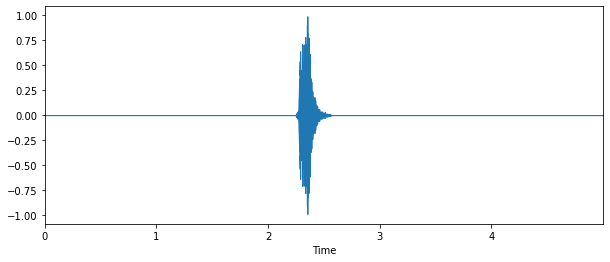

In [0]:
#dATASET...DOG BARKING....
print("Dog...")
dir_1 = "/content/datasets/esc/esc50/ESC-50-master/audio/1-100032-A-0.wav"
plt.figure(figsize=(10,4))
data,sample_rate = librosa.load(dir_1)
print('sampling rate:', sample_rate)
print('wav shape:', data.shape)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(dir_1)

Bird chirping...
sampling rate:  22050
wav shape:  (110250,)


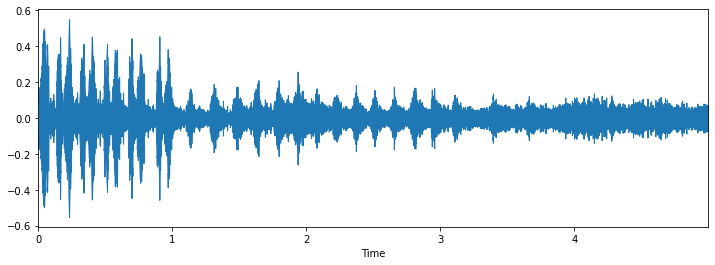

In [0]:
#dATASET...bird chirping BARKING....
print("Bird chirping...")
dir_2 = "/content/datasets/esc/esc50/ESC-50-master/audio/1-100038-A-14.wav"
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(dir_2)
print('sampling rate: ', sample_rate)
print('wav shape: ', data.shape)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(dir_2)

Thurderstorm ....
sampling rate:  22050
wav shape:  (110250,)


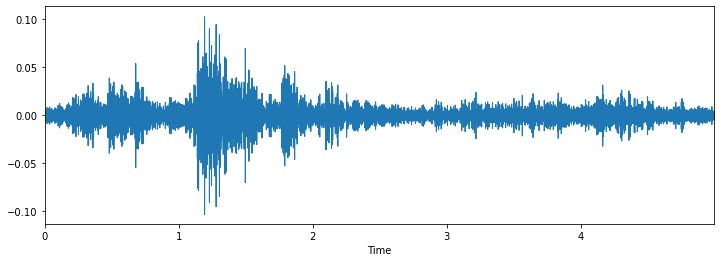

In [0]:
#dATASET...bird chirping BARKING....
print("Thurderstorm ....")
dir_3 = "/content/datasets/esc/esc50/ESC-50-master/audio/1-101296-A-19.wav"
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(dir_3)
print('sampling rate: ', sample_rate)
print('wav shape: ', data.shape)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(dir_3)

hen ....
sampling rate:  22050
wav shape:  (110250,)


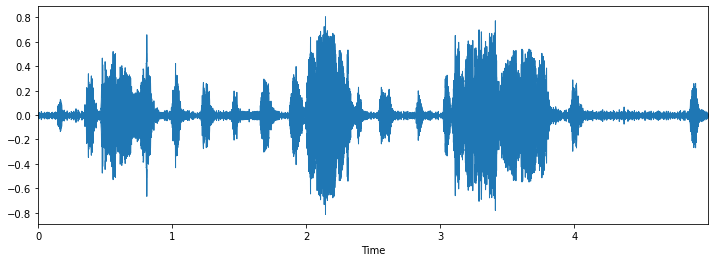

In [0]:
#...sound of a hen,...
print("hen ....")
dir_4 = "/content/datasets/esc/esc50/ESC-50-master/audio/5-263831-B-6.wav"
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(dir_4)
print('sampling rate: ', sample_rate)
print('wav shape: ', data.shape)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(dir_4)

hen ....
sampling rate:  22050
wav shape:  (110250,)


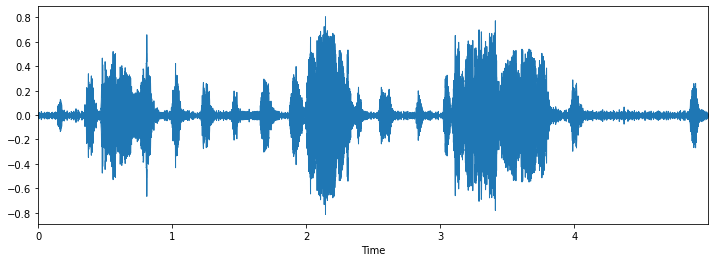

In [0]:
#...sound of a vacuum clearner,...
print("hen ....")
dir_5 = "/content/datasets/esc/esc50/ESC-50-master/audio/5-263902-A-36.wav"
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(dir_4)
print('sampling rate: ', sample_rate)
print('wav shape: ', data.shape)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(dir_5)

- Librosa’s load function will also normalise the data so it's values range between -1 and 1. 

- This removes the complication of the dataset having a wide range of bit-depths.

In [0]:
audio_data,sample_rate = librosa.load(dir_1)  
scipy_sample_rate,scipy_audio_data = wav.read(dir_1) #loading with scipyWavfile

In [0]:
print('Original audio file min~max range:', onp.min(scipy_audio_data), 'to', onp.max(scipy_audio_data))
print('Librosa audio file min~max range:', onp.min(audio_data), 'to', onp.max(audio_data))

Original audio file min~max range: -31732 to 32730
Librosa audio file min~max range: -0.9219781 to 0.9858924


**Merge audio channels**

- Librosa will also convert the signal to mono, meaning the number of channels will always be 1.

Original audio with 2-channels


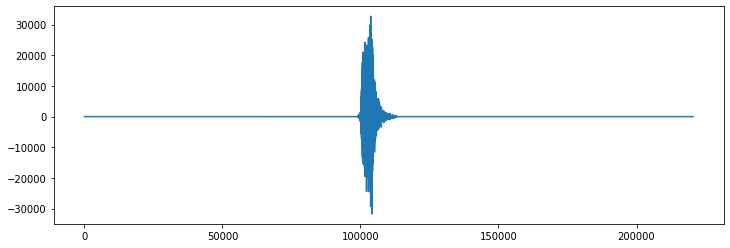

Librosa audio with channels merged..


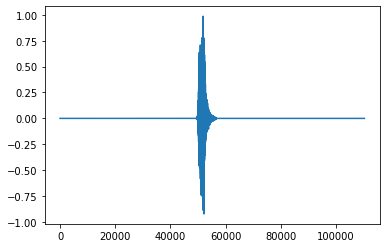

In [0]:
#original audio with 2-channels
print("Original audio with 2-channels")
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio_data)
plt.show()

#Librosa audio with channels merged..
print("Librosa audio with channels merged..")
plt.plot(figsize=(12,4))
plt.plot(audio_data)
plt.show()

###Feature Extraction with Librosa 

- I  will be extracting the  MFCC (Mel-Frequency Cepstral Coefficients)

- In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

- The MFCC summarises the frequency distribution across the window size, 

- so it is possible to analyse both the frequency and time characteristics of the sound. 

- These audio representations will allow me to identify features for classification.



- To extract the MFCC;

- **Librosa's mfcc()** function **which generates an MFCC from time series audio data** will be used

In [0]:
MFCCS = librosa.feature.mfcc(y=audio_data,
                             sr = sample_rate,
                             n_mfcc = 40)

In [0]:
                        #checking the shape of the MFCC
MFCCS.shape

(40, 216)

- 40 MFCCs over 216 frames

In [0]:
#scaling the MFCC...                   
MFCCS_scaled = onp.mean(MFCCS,axis=1)   #taking mean along each row ...
MFCCS_scaled                  

array([-6.00969171e+02,  4.73532961e+00, -8.54689367e+00, -4.23580197e+00,
       -8.59240473e-01, -1.93306211e+00, -3.34689660e-01,  8.65150781e-01,
        7.82124857e-01,  4.79820345e-01, -5.15049145e-01, -2.08493385e-01,
       -8.98010119e-01,  4.96115308e-01, -1.15486280e-01, -3.00109234e-01,
       -1.14665993e+00, -6.04943002e-02, -1.57216271e-01,  5.01119004e-01,
       -7.07625455e-01, -5.34732164e-01,  3.07062958e-01, -2.25185776e-01,
       -4.37486544e-01, -9.48169190e-03, -3.23779787e-01,  3.67366954e-01,
       -4.05892049e-01, -3.19845775e-01,  1.31177814e-02,  5.63611754e-01,
       -7.76200387e-02,  1.28231870e-01, -4.78724190e-01, -1.15911091e-01,
        1.65006218e-01, -3.84443241e-02, -1.07893075e-01,  1.13991837e-01])

In [0]:
MFCCS_scaled.shape

(40,)

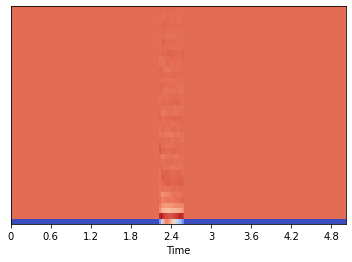

In [0]:
                                                 #viewing the MFCCs
librosa.display.specshow(MFCCS,sr = sample_rate, x_axis = 'time')

In [0]:
                                #function to extarct MFCC for all audio sample..
def mfcc_extraction(audio_file):
  try:
    audio_data,sample_rate = librosa.load(audio_file,res_type='kaiser_fast')
    get_MFCC = librosa.feature.mfcc(y=audio_data,sr = sample_rate,n_mfcc=40)
    MFCCS_scaled = onp.mean(get_MFCC,axis=1)
  except Exception as e:
    print("Error encountered while parsing file: ",audio_file)
    return None
  return MFCCS_scaled

In [0]:
                  #TESTING FEATURE ON SINGLE DATA_
mfcc_extraction(dir_1)

array([-6.01344945e+02,  5.26140823e+00, -9.06538852e+00, -3.72975965e+00,
       -1.34822554e+00, -1.46515438e+00, -7.77630593e-01,  1.28019300e+00,
        3.97516454e-01,  8.32053258e-01, -8.33717411e-01,  7.60978743e-02,
       -1.14853376e+00,  7.13100445e-01, -3.00012164e-01, -1.46493545e-01,
       -1.27124856e+00,  3.71667937e-02, -2.30218073e-01,  5.51845968e-01,
       -7.38523111e-01, -5.21251100e-01,  3.08674523e-01, -2.39720463e-01,
       -4.12020825e-01, -4.40792863e-02, -2.81657033e-01,  3.19135638e-01,
       -3.52773377e-01, -3.76803802e-01,  7.30463012e-02,  5.01443540e-01,
       -1.37950360e-02,  6.32389150e-02, -4.12953007e-01, -1.82122026e-01,
        2.31382821e-01, -1.04729751e-01, -4.19195259e-02,  4.85401087e-02])

In [0]:
DATA_PATH = "/content/datasets/esc/esc50/ESC-50-master/audio/"
features = []

In [0]:
#iterate through each sound file and extract the features...
for index, row in df_esc50.iterrows():
  audio_file = os.path.join(os.path.abspath(DATA_PATH),str(row["filename"]))
  class_label = row['category']
  audio_data  = mfcc_extraction(audio_file)
  features.append([audio_data,class_label])

In [0]:
#features....
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [0]:
featuresdf.head()

,feature,class_label
0,"[-601.344944808394, 5.2614082261637884, -9.065...",dog
1,"[-200.65909506056875, 12.515456415611007, -69....",chirping_birds
2,"[7.545552539995939, 69.50337381031625, -21.425...",vacuum_cleaner
3,"[8.940391242994831, 67.527899346432, -19.81801...",vacuum_cleaner
4,"[-428.37644414305834, 132.65819143400066, 31.1...",thunderstorm


In [0]:
featuresdf.shape

(2000, 2)

In [0]:
#featuresdf.to_csv('features_df.csv')

In [0]:
                              #getting the uniquetargets.....
featuresdf.class_label.unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [0]:
                          #num of targets.....
featuresdf.class_label.nunique()

50

In [0]:
                          #Converting features and corresponding 
                          #classification labels into numpy arrays
X = onp.array(featuresdf.feature.tolist())
y = onp.array(featuresdf.class_label.tolist())

                         #Encoding the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [0]:
print("X_shape : ", X.shape)
print("X_shape : ",yy.shape)

X_shape :  (2000, 40)
X_shape :  (2000, 50)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
print("X_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("X_test shape  : ", x_test.shape)
print("y_test shape  : ", y_test.shape)

X_train shape :  (1600, 40)
y_train shape :  (1600, 50)
X_test shape  :  (400, 40)
y_test shape  :  (400, 50)


###First Model attempt with MLP in JAX

- The following functions are needed to train a MultiLayer perceptron

- A function that **initialzes the weights of the Neural Network**, and returns a list of layer-specific parameters

- A function that performs **forward pass** through the network

- A function that performs **cross-entropy loss** of the predictions

- A function that **evaluates the accuracy** of the prediction

- A function that **updates the parameters** using some form of gradient descent

- The first layer will receive the input shape. As each sample contains 40 MFCCs (or columns) 

- I then have a shape of (1x40) this means we will start with an input shape of 40.

- The first two layers will have 512 nodes. 

In [0]:
                                              #defining the ReLu activation function - "Rectified Linear Unit"
def ReLu(x):
  return jnp.maximum(0,x)
                                                #speeding this up with jit
jit_ReLu = jit(ReLu)    

def relu_layer(weight,bias,x):                   #ReLu(x) == np.max(0,x)
  Relu_output = ReLu(jnp.dot(weight,x) + bias)   #ReLu(y = XW + b)
  return Relu_output 

def relu_layer_batched(weight,bias,x):
  Batched_Relu = ReLu(jnp.dot(x,weight.T) + bias)   #ReLu(y = XW.T + b)
  return Batched_Relu

                                                    #creating a one-hot encoding of x of size k...
def one_hot(x,k,dtype=jnp.float32):
  return jnp.array(x[:,None] == jnp.arange(k),dtype)  

def relu_layer_vmap(weight,bias,x):                 #simply put the ReLu_layer in "vmap" and then "jit" it 
  vmap_relu = jit(vmap(relu_layer,in_axes=(None,0),out_axes=0))  
  return vmap_relu  

In [0]:
def initialize_mlp(sizes,key):                 #func for initilization of parameters 
  all_ex_last  = sizes[:-1] 
  all_ex_first = sizes[1:]
  keys = random.split(key,len(sizes))
  def initilize_layer(m,n,key,scale=1e-2):
    w_key,b_key = random.split(key)
    scale_1 = scale*random.normal(w_key,(n,m))
    scale_2 = scale*random.normal(b_key,(n,))
    return scale_1,scale_2
  return [initilize_layer(m,n,k) for m,n,k in zip(all_ex_last,all_ex_first,keys)]


In [0]:
layer_size = [40, 512, 512 , 50]            #input =[40] || then 2-hidden_layers each of size [512] || num_clases = 50
params= initialize_mlp(layer_size,key)      

In [0]:
def forward_pass(params,in_layer):
  activations = in_layer                          #each layer's output... == another layer's input
  for w,b in params[:-1]:                         #looping over the ReLu hidden layers
    activations = relu_layer(w,b,activations)

  final_w,final_b = params[-1]
  logits = jnp.dot(final_w,activations) + final_b   #logits = layer_output[-1]
  return logits - logsumexp(logits)                 #logsumexp() from jax

                                                    #batching the forward_pass
batch_forward = vmap(forward_pass, 
                     in_axes=(None, 0), 
                     out_axes=0)  

In [0]:
@jax.jit                                    #computing a multiclass cross-entropy loss
def loss(params,in_layer,targets):
  preds = batch_forward(params,in_layer)    #batch_forward is vectorized version of the forward_pass,   
  loss = -jnp.sum(preds*targets)            #and it returns teh prediction
  return loss

@jax.jit                                         #computing accuracy....
def accuracy(params,data,targets):
  target_class = jnp.argmax(targets,axis=1)      #targets== already 0ne -hot endcoded
  pred_class = jnp.argmax(batch_forward(params,data),axis=1)  #in_layer == data_sample
  acc = jnp.mean(pred_class == target_class)
  return acc
  
@jax.jit                                          #function that computes the gradient 
def update(params,x,y,opt_state):                 #for a batch and update the parameters
  value, grad = value_and_grad(loss)(params,x,y)  #value_and_grad() computes a function and its gradient
  opt_state = opt_update(0,grad,opt_state)
  return get_params(opt_state),opt_state,loss

step_size = 1e-3
opt_init,opt_update,get_params = optimizers.adam(step_size)  #Adam optimizer from JAX
opt_state = opt_init(params)
num_epochs = 100
num_classes = 50  

In [0]:
 def training_loop(num_epochs, opt_state):
    log_acc_train, log_acc_test, train_loss = [], [], []                                    
    params = get_params(opt_state)                 #Get the initial set of parameters
    train_acc = accuracy(params,x_train,y_train)   #Get initial accuracy after random init
    test_acc = accuracy(params,x_test,y_test)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

                                                    #Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params,
                                         x_train,
                                         y_train,
                                         opt_state)
        train_loss.append(loss)
        epoch_time = time.time() - start_time
        train_acc = accuracy(params,x_train,y_train)
        test_acc = accuracy(params,x_test,y_test)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train Acc: {:0.3f} | Test Acc: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

        #display.clear_output(wait=True)  
    return train_loss, log_acc_train, log_acc_test

In [0]:
train_loss, train_log, test_log = training_loop(num_epochs,opt_state)

Epoch 1 | T: 0.01 | Train Acc: 0.034 | Test Acc: 0.037
Epoch 2 | T: 0.00 | Train Acc: 0.046 | Test Acc: 0.050
Epoch 3 | T: 0.00 | Train Acc: 0.097 | Test Acc: 0.095
Epoch 4 | T: 0.00 | Train Acc: 0.118 | Test Acc: 0.102
Epoch 5 | T: 0.00 | Train Acc: 0.138 | Test Acc: 0.110
Epoch 6 | T: 0.00 | Train Acc: 0.186 | Test Acc: 0.162
Epoch 7 | T: 0.00 | Train Acc: 0.199 | Test Acc: 0.167
Epoch 8 | T: 0.00 | Train Acc: 0.227 | Test Acc: 0.177
Epoch 9 | T: 0.00 | Train Acc: 0.241 | Test Acc: 0.192
Epoch 10 | T: 0.00 | Train Acc: 0.247 | Test Acc: 0.185
Epoch 11 | T: 0.00 | Train Acc: 0.274 | Test Acc: 0.220
Epoch 12 | T: 0.00 | Train Acc: 0.281 | Test Acc: 0.227
Epoch 13 | T: 0.00 | Train Acc: 0.305 | Test Acc: 0.205
Epoch 14 | T: 0.00 | Train Acc: 0.319 | Test Acc: 0.255
Epoch 15 | T: 0.00 | Train Acc: 0.328 | Test Acc: 0.265
Epoch 16 | T: 0.00 | Train Acc: 0.332 | Test Acc: 0.242
Epoch 17 | T: 0.00 | Train Acc: 0.334 | Test Acc: 0.257
Epoch 18 | T: 0.01 | Train Acc: 0.366 | Test Acc: 0.250
E

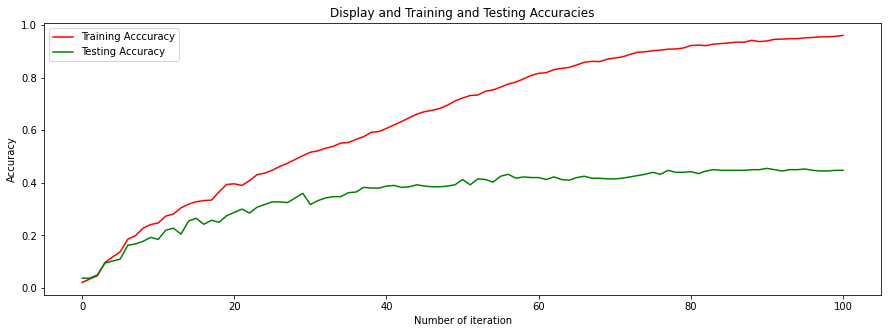

In [0]:
plt.figure(figsize=(15,5))
plt.plot(train_log, 'r', label ='Training Acccuracy')
plt.plot(test_log, 'g', label ="Testing Accuracy")
plt.xlabel('Number of iteration')
plt.ylabel('Accuracy')
plt.title('Display and Training and Testing Accuracies')
plt.legend(loc = 'best')
plt.show()

In [0]:
                                  #how to build MLP with Haiku simply...
def mlp_net(x):
  mlp = hk.Sequential([
                       hk.Flatten(),
                       hk.Linear(512),  #1st layer...
                       jax.nn.relu,
                       hk.Linear(512),  #2nd layer....
                       jax.nn.relu,
                       hk.Linear(50),   #output
                       ])
  return mlp(x)


#x.train = (40,512,512,50)
#key = jax.random.PRNGKey(42)
#net = hk.transform(mlp_net)         #"hk.transform" on MLP_Network 
#params  = net.init(key,x_train)    #Initialize network and optimizer; 





#Second Model attempt with CNN JAX

- Modification of feature extraction

- In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files.

- However, CNNs require a fixed size for all inputs.

- To overcome this, zero padding the output vectors to make them all the same size.

In [0]:
                                      #function to extract MFCC for all audio sample..
max_pad_len = 217
def mfcc_extraction_pad(audio_file):
  try:
    audio_data,sample_rate = librosa.load(audio_file,res_type='kaiser_fast')
    get_MFCC = librosa.feature.mfcc(y=audio_data,sr = sample_rate,n_mfcc=40)
    pad_width = max_pad_len - get_MFCC.shape[1]
    MFCCS = onp.pad(get_MFCC,pad_width=((0, 0),
                                        (0, pad_width)),
                                        mode='constant')
  except Exception as e:
    print("Error encountered while parsing file: ",audio_file)
    return None
  return MFCCS

In [0]:
DATA_PATH = "/content/datasets/esc/esc50/ESC-50-master/audio/"
features = []

In [0]:
                                        #TESTING FEATURE ON SINGLE DATA_
dir_1 = "/content/datasets/esc/esc50/ESC-50-master/audio/1-100038-A-14.wav"
single_mfcc = mfcc_extraction_pad(dir_1)
single_mfcc

array([[-165.33815931, -173.28544807, -186.74277127, ..., -200.36679428,
        -186.45015152,    0.        ],
       [ -15.33190469,   -7.42953846,   -2.64670141, ...,   22.30669273,
          24.34957123,    0.        ],
       [ -59.60990931,  -55.79108069,  -60.77199589, ...,  -58.63007993,
         -40.35482878,    0.        ],
       ...,
       [   9.90102115,   12.30867   ,   19.1720489 , ...,   -3.67531927,
          -2.68250801,    0.        ],
       [  -3.42188238,   -6.90058737,  -13.13680929, ...,   -1.1220864 ,
           3.09628127,    0.        ],
       [   8.09354875,    9.27744589,   11.49644265, ...,    2.39898946,
          10.08636075,    0.        ]])

In [0]:
single_mfcc.shape

(40, 217)

In [0]:
                                   #iterate through each sound file and extract the features...
for index, row in df_esc50.iterrows():
  audio_file = os.path.join(os.path.abspath(DATA_PATH),str(row["filename"]))
  class_label = row['category']
  audio_data  = mfcc_extraction_pad(audio_file)
  features.append([audio_data,class_label])

In [0]:
                                   #features....
featuresdf_new = pd.DataFrame(features, columns=['feature','class_label'])

In [0]:
featuresdf_new.head()

,feature,class_label
0,"[[-629.0347579657414, -629.0347579657414, -629...",dog
1,"[[-165.33815931479825, -173.28544807355715, -1...",chirping_birds
2,"[[-68.57624180788548, -75.26595022562017, -82....",vacuum_cleaner
3,"[[19.57786258394988, 20.115192011435493, 16.68...",vacuum_cleaner
4,"[[-446.0381550382831, -444.05035045796683, -44...",thunderstorm


In [0]:
featuresdf_new.shape

(2000, 2)

In [0]:
X = onp.array(featuresdf_new.feature.tolist())
y = onp.array(featuresdf_new.class_label.tolist())

                                        #Encoding the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

                                        #split the dataset 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [0]:
print("X_shape : ", X.shape)
print("y_shape : ",yy.shape)

X_shape :  (2000, 40, 217)
y_shape :  (2000, 50)


In [0]:
print("X_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("X_test shape  : ", x_test.shape)
print("y_test shape  : ", y_test.shape)

X_train shape :  (1600, 40, 217)
y_train shape :  (1600, 50)
X_test shape  :  (400, 40, 217)
y_test shape  :  (400, 50)


###CNN with JAX

In [0]:
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm,Conv,Dense,Flatten,Relu,Dropout,
                                   AvgPool, MaxPool, LogSoftmax)

In [0]:
                            #jax.random.PRNGKey 
key = random.PRNGKey(1)
key,subkey = random.split(key)

In [0]:
                            #Stax.serial to get all layers together
                            #init_fun for initialization of paramters
                            #pred == conv_net returns prediction || forward pass 
init_fun,pred = stax.serial(Conv(32,(5,5),(2,2),padding="SAME"),
                            BatchNorm(),Relu, MaxPool((2,2)), #Dropout(2,mode='train'),
                                
                            Conv(64,(5,5),(2,2),padding="SAME"),
                            BatchNorm(),Relu,  MaxPool((2,2)), #Dropout(2,mode='train'),

                            Conv(128,(3,3),(2,2),padding="SAME"),
                            BatchNorm(),Relu,  #MaxPool((2,2)),Dropout(2,mode='train'),
                            
                            Conv(256,(3,3),(2,2),padding="SAME"),
                            BatchNorm(),Relu,  #MaxPool((2,2)),  Dropout(2,mode='train'),
                            AvgPool((2,2)),
                            Flatten,
                            Dense(num_classes),
                            LogSoftmax)

In [0]:
                            #init_fun == function for the initilization of parameters..... 
batch_size = 128   
out_shape,params = init_fun(key,(batch_size,40,216,1))                           

In [0]:
num_rows = 40
num_columns = 217
num_channel = 1
X_train = x_train.reshape(x_train.shape[0],num_rows,num_columns,num_channel)
X_test = x_test.reshape(x_test.shape[0],num_rows,num_columns,num_channel)
print("Print X_train new shape: ", X_train.shape)
print("Print X_test new shape: ", X_test.shape)

Print X_train new shape:  (1600, 40, 217, 1)
Print X_test new shape:  (400, 40, 217, 1)


In [0]:
@jax.jit
def accuracy(params,data,targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(pred(params, data), axis=1)
    acc_total = jnp.sum(predicted_class == target_class)
    return acc_total/len(data)


@jax.jit
def loss(params,images,targets):
  preds = pred(params,images)       #con_net == predict() 
  loss_cnn = -jnp.sum(preds*targets)
  return loss_cnn  


@jax.jit
                                     #function that computes the gradient for a batch and update the parameters
def update(params,x,y,opt_state):
  value, grad = value_and_grad(loss)(params,x,y)  #value_and_grad() computes a function and its gradient
  opt_state = opt_update(0,grad,opt_state)
  return get_params(opt_state),opt_state,loss


                                    #defining optimizer from Jax
num_epochs = 100
num_classes = 50
step_size = 1e-3
opt_init,opt_update,get_params = optimizers.adam(step_size)
opt_state = opt_init(params) 

In [0]:
 def training_loop(num_epochs, opt_state):
    log_acc_train, log_acc_test, train_loss = [], [], []                                    
    params = get_params(opt_state)                 #Get the initial set of parameters
    train_acc = accuracy(params,X_train,y_train)   #Get initial accuracy after random init
    test_acc = accuracy(params,X_test,y_test)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
                                                  #Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params,
                                         X_train,
                                         y_train,
                                         opt_state)
        train_loss.append(loss)
        epoch_time = time.time() - start_time
        train_acc = accuracy(params,X_train,y_train)
        test_acc = accuracy(params,X_test,y_test)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train Acc: {:0.3f} | Test Acc: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
         
    return train_loss, log_acc_train, log_acc_test

In [0]:
train_loss, train_log, test_log = training_loop(num_epochs,opt_state)

Epoch 1 | T: 4.72 | Train Acc: 0.087 | Test Acc: 0.067
Epoch 2 | T: 0.03 | Train Acc: 0.194 | Test Acc: 0.142
Epoch 3 | T: 0.03 | Train Acc: 0.238 | Test Acc: 0.195
Epoch 4 | T: 0.03 | Train Acc: 0.263 | Test Acc: 0.218
Epoch 5 | T: 0.03 | Train Acc: 0.314 | Test Acc: 0.225
Epoch 6 | T: 0.03 | Train Acc: 0.354 | Test Acc: 0.230
Epoch 7 | T: 0.03 | Train Acc: 0.436 | Test Acc: 0.357
Epoch 8 | T: 0.03 | Train Acc: 0.496 | Test Acc: 0.362
Epoch 9 | T: 0.03 | Train Acc: 0.558 | Test Acc: 0.403
Epoch 10 | T: 0.03 | Train Acc: 0.600 | Test Acc: 0.440
Epoch 11 | T: 0.03 | Train Acc: 0.614 | Test Acc: 0.465
Epoch 12 | T: 0.03 | Train Acc: 0.664 | Test Acc: 0.512
Epoch 13 | T: 0.03 | Train Acc: 0.703 | Test Acc: 0.517
Epoch 14 | T: 0.03 | Train Acc: 0.731 | Test Acc: 0.553
Epoch 15 | T: 0.03 | Train Acc: 0.762 | Test Acc: 0.585
Epoch 16 | T: 0.03 | Train Acc: 0.783 | Test Acc: 0.575
Epoch 17 | T: 0.03 | Train Acc: 0.808 | Test Acc: 0.585
Epoch 18 | T: 0.03 | Train Acc: 0.832 | Test Acc: 0.585
E

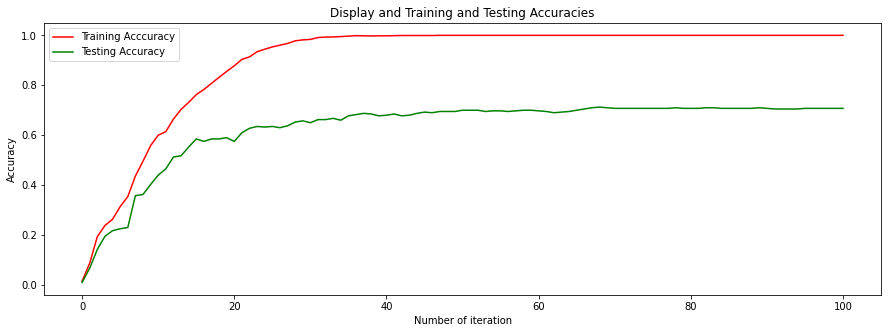

In [0]:
plt.figure(figsize=(15,5))
plt.plot(train_log, 'r', label ='Training Acccuracy')
plt.plot(test_log, 'g', label ="Testing Accuracy")
plt.xlabel('Number of iteration')
plt.ylabel('Accuracy')
plt.title('Display and Training and Testing Accuracies')
plt.legend(loc = 'best')
plt.show()